# 2023 CMAQ-CRACMM Project: PM2.5 and Age
---
    author: Havala O.T. Pye (pye.havala@epa.gov)
    date: created 2025-010-07
---
For Lu Xu, WUSTL

In [ ]:
%matplotlib inline

In [2]:
# Libraries and packages
import cmaqsatproc as csp
import pandas as pd
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
import numpy as np
import glob
import netCDF4
from netCDF4 import Dataset
import PseudoNetCDF as pnc
from datetime import datetime, timedelta, date
import warnings
import scipy
from scipy.stats import bootstrap
import math
from IPython.display import display
import ast
import adjustText 
import textalloc as ta
import plotly
import plotly.express as px
import nbformat
from scipy.stats import gaussian_kde


import pyrsig
import pycno
from dateutil import rrule
import cmaps

In [3]:
# print versions
print('csp version:    ' +csp.__version__)
print('pandas version: ' +pd.__version__)
print('xr version:     ' +xr.__version__)
print('cartopy version:' +cartopy.__version__)
print('Numpy version:  ' +np.__version__)
print('Netcdf4 version:' +netCDF4.__version__)
print('pnc version:    ' +pnc.__version__)
print('pyrsig version: ' +pyrsig.__version__)
print('pyncno version: ' +pycno.__version__)

csp version:    0.2.4
pandas version: 1.5.1
xr version:     2023.11.0
cartopy version:0.22.0
Numpy version:  1.22.3
Netcdf4 version:1.6.5
pnc version:    3.2.2
pyrsig version: 0.10.0
pyncno version: 0.3.0


In [4]:
today = str(date.today())
today = today.replace('-','')
print('Last run on YYYYMMDD '+str(today))

Last run on YYYYMMDD 20251008


In [5]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [6]:
# set verbose to true to make more documentation
verbose = False

# Setup

In [7]:
# Major file locations
workdir = '/work/MOD3DEV/has/2023cracmm_ages/analysis/scripts/postestl/'
outdir = workdir + './output/' # for saving csv output and plots
datadir = workdir + './data/'   # input data

In [8]:
# proj4 info and lat/lon info (get these files from: https://cmaq-12us4-cracmm3-modeling-platform-2023.s3.amazonaws.com/index.html#2023_12US4/met/)
metpath = '/work/MOD3DATA/2023_12US4/met/'
m2dpath = metpath + 'METCRO2D.12US4.35L.230701'
g2dpath = metpath + 'GRIDCRO2D.12US4.35L.230701'

In [9]:
# Display the proj4 string
f = pyrsig.open_ioapi(m2dpath)  
f.crs_proj4
cno = pycno.cno(f.crs_proj4)

In [10]:
def set_map( ax, title, colorlabel ):
    ax.colorbar.set_label(colorlabel)
    ax.axes.set_xlabel('')
    ax.axes.set_xticklabels('')
    ax.axes.set_ylabel('')
    ax.axes.set_yticklabels('')
    plt.setp(ax.axes, **dict(title=title))
    cno.drawstates( ax=ax.axes, linewidth=0.2 )

## June concentrations and time

In [11]:
# CMAQv6a1 CRACMM3
cmaqbasedata = '/work/MOD3DEV/has/2023cracmm_ages/runs/20250905cmaq6acracmm3_base/data/POST/COMBINE_ACONC_2023_12US4_202306.nc'
cmaqnofiredata = '/work/MOD3DEV/has/2023cracmm_ages/runs/20250905cmaq6acracmm3_nofire/data/POST/COMBINE_ACONC_2023_12US4_202306.nc'

# CMAQv55 CRACMM2
#cmaqbasedata = '/work/MOD3DEV/has/2023cracmm_ages/runs/20250909v55cracmm2_base/data/POST/COMBINE_ACONC_2023_12US4_202306.nc'
#cmaqnofiredata = '/work/MOD3DEV/has/2023cracmm_ages/runs/20250909v55cracmm2_nofire/data/POST/COMBINE_ACONC_2023_12US4_202306.nc'

baseconc = pyrsig.open_ioapi(cmaqbasedata)    
nofireconc = pyrsig.open_ioapi(cmaqnofiredata)  

In [12]:
# mean changes (2-D mean in time)
pm25_ugm3   = baseconc['PM25_TOT'].mean(dim='TSTEP')-nofireconc['PM25_TOT'].mean(dim='TSTEP')
co_ppb      = baseconc['CO'].mean(dim='TSTEP')-nofireconc['CO'].mean(dim='TSTEP')
benzene_ppb = baseconc['BENZENE'].mean(dim='TSTEP')-nofireconc['BENZENE'].mean(dim='TSTEP')
toluene_ppb = baseconc['TOLUENE'].mean(dim='TSTEP')-nofireconc['TOLUENE'].mean(dim='TSTEP')
co_ugm3     = ((baseconc['CO']-nofireconc['CO'])*baseconc['AIR_DENS']*28.01/28.9628).mean(dim='TSTEP')  # AIR_DENS is density of air in kg/m3 (function of meteorology fields)

In [13]:
# calc photochemical age (2-D mean in time)
bentotolinitial = 2.27 #ptothna input, emission molar ratio
bentoltime = (benzene_ppb)/(toluene_ppb)
bentoltime = np.log(bentoltime/bentotolinitial)/(5.9337*10**(-12)-1.2196*10**(-12))/3600/24/1e6 # 1e6 mole/cm3 OH assumed


/home/phavala/.local/lib/python3.9/site-packages/xarray/core/computation.py:821: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/phavala/.local/lib/python3.9/site-packages/xarray/core/computation.py:821: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


In [14]:
#benzene_ppb.median()

## Concentration map (mean in time)

base min, max:    1.1351641,901.36334
no fire min, max: 1.0048399,57.600224
delta min, max:   -0.0026557446,898.55853


/home/phavala/.local/lib/python3.9/site-packages/matplotlib/colors.py:737: RuntimeWarning: invalid value encountered in less
  mask_under = xa < 0
/home/phavala/.local/lib/python3.9/site-packages/matplotlib/colors.py:738: RuntimeWarning: invalid value encountered in greater_equal
  mask_over = xa >= self.N


delta % min, max: -0.10842809,99.68883


/home/phavala/.local/lib/python3.9/site-packages/matplotlib/colors.py:737: RuntimeWarning: invalid value encountered in less
  mask_under = xa < 0
/home/phavala/.local/lib/python3.9/site-packages/matplotlib/colors.py:738: RuntimeWarning: invalid value encountered in greater_equal
  mask_over = xa >= self.N


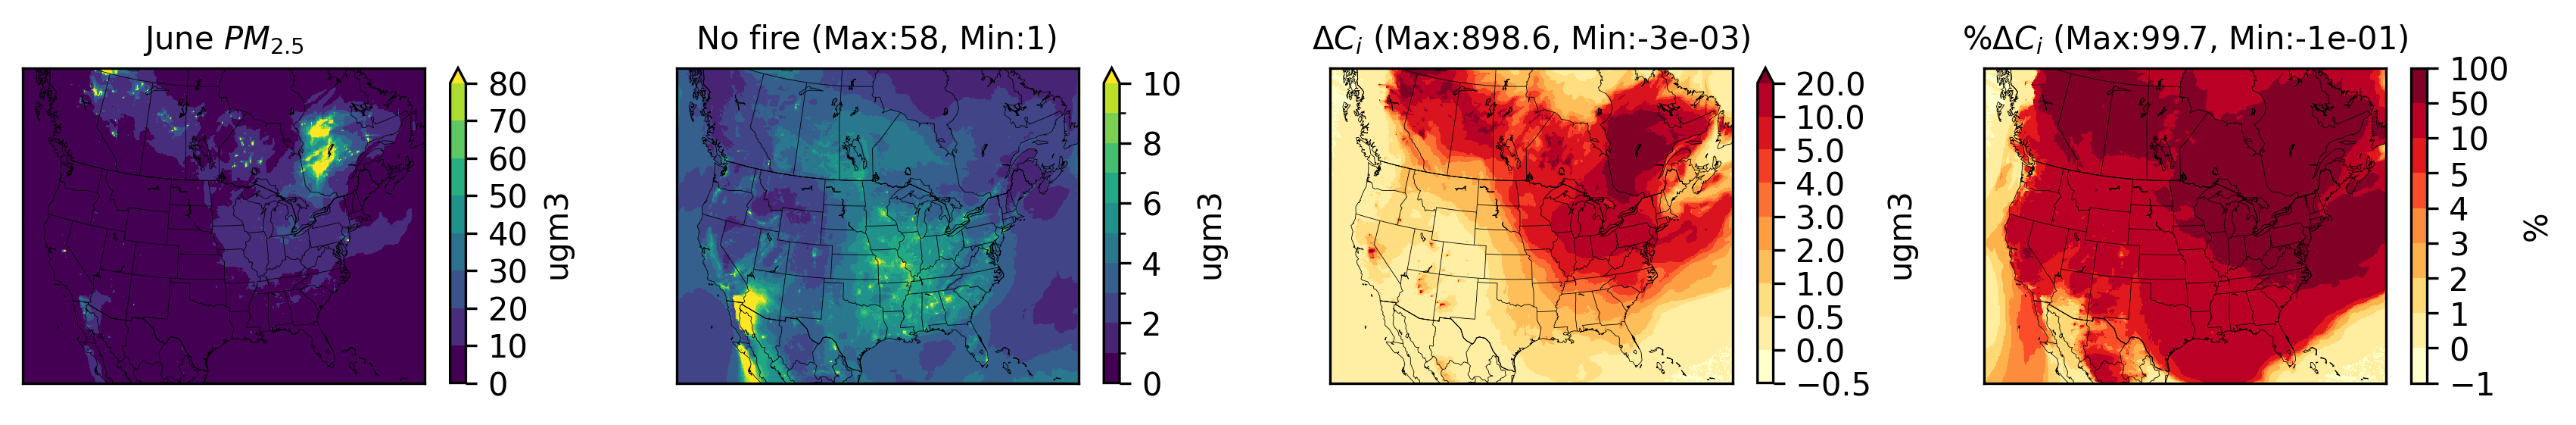

In [15]:
spc = 'PM25_TOT' # spc to read from baseconc and nofire
units = 'ugm3'
printname = '$PM_{2.5}$'
colmap = plt.get_cmap('YlOrRd')
          
##################    
# Panel B0 base in base units
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['figure.figsize'] = [14, 1.8]
f1, sax = plt.subplots(1,4,dpi=300)
plt.subplots_adjust(wspace=0.3)

# Panel B0 base simulation
plt.sca(sax[0])
lab= units
conc = baseconc[spc].mean(dim='TSTEP')
print("base min, max:    "+str(conc.min().values)+','+str(conc.max().values))
minval = 10**(round(np.log10(float(conc.min())),0))
maxval = 10**(round(np.log10(float(conc.max())),0))
levelsforplot = np.array([0,10,20,30,40,50,60,70,80])
levelsforplot = list(levelsforplot)
plotvar = conc.plot(cmap='viridis',levels=levelsforplot)#norm=norm)
title= 'June '+ printname 
sax[0].axes.set_xticks([])
sax[0].axes.set_yticks([])
set_map( ax=plotvar, title=title, colorlabel=lab )

# Panel B1 nofire in mass
plt.sca(sax[1])
lab= units
conc = nofireconc[spc].mean(dim='TSTEP')
print("no fire min, max: "+str(conc.min().values)+','+str(conc.max().values))
levelsforplot = np.array([0,1,2,3,4,5,6,7,8,9,10])
levelsforplot = list(levelsforplot)
plotvar = conc.plot(cmap='viridis',levels=levelsforplot)#norm=norm)
title= 'No fire (Max:' + '{:.0f}'.format(conc.max().values) + \
                    ', Min:' + '{:.0f}'.format(conc.min().values)+')'
sax[1].axes.set_xticks([])
sax[1].axes.set_yticks([])
set_map( ax=plotvar, title=title, colorlabel=lab )

# Panel B2-- fire delta in mass (impact of fires--positive means fires increased species)
plt.sca(sax[2])
lab= units
conc = baseconc[spc].mean(dim='TSTEP')-nofireconc[spc].mean(dim='TSTEP')
print("delta min, max:   "+str(conc.min().values)+','+str(conc.max().values))
maxval = conc.max().values
minval = conc.min().values
levelsforplot = np.array([-0.5,0,0.5,1,2,3,4,5,10,20])
levelsforplot = list(levelsforplot)
plotvar = conc.plot(cmap=colmap,levels=levelsforplot)
title= '$\Delta$$C_i$ (Max:' + str(round(float(conc.max()),1)) + \
                    ', Min:' + '{:.0e}'.format(conc.min().values)+')'
sax[2].axes.set_xticks([])
sax[2].axes.set_yticks([])
set_map( ax=plotvar, title=title, colorlabel=lab )

# Panel B3-- fire delta in percent (impact of fires--positive means fires increased species)
plt.sca(sax[3])
lab= '%'
conc = (baseconc[spc].mean(dim='TSTEP')-nofireconc[spc].mean(dim='TSTEP'))/baseconc[spc].mean(dim='TSTEP')*100
print("delta % min, max: "+str(conc.min().values)+','+str(conc.max().values))
maxval = conc.max().values
minval = conc.min().values
levelsforplot = np.array([-1,0,1,2,3,4,5,10,50,100])
levelsforplot = list(levelsforplot)
plotvar = conc.plot(cmap=colmap,levels=levelsforplot)#norm=norm)
title= '%$\Delta$$C_i$ (Max:' + str(round(float(conc.max()),1)) + \
                    ', Min:' + '{:.0e}'.format(conc.min().values)+')'
sax[3].axes.set_xticks([])
sax[3].axes.set_yticks([])
set_map( ax=plotvar, title=title, colorlabel=lab )

plt.show()

# Values relative to CO and vs time

In [16]:
grid = pnc.pncopen( g2dpath, format ='ioapi' )
sites = pd.read_csv(datadir+'cities.txt',header=None)
sites = sites.rename(columns={1:"lon",2:"lat",0: 'site'})
sites

#sites = sites[sites['site'] != 'MacKenzie Co.']
#sites = sites[sites['site'] != 'Calgary']

,site,lon,lat
0,NYC,-74.006000,40.712800
1,Chicago,-87.629800,41.878100
2,Toronto,-79.347015,43.651070
3,Montreal,-73.561668,45.508888
4,Vancouver,-123.116226,49.246292
5,Calgary,-114.066666,51.049999
6,Ottawa,-75.695000,45.424721
7,Edmonton,-113.323975,53.631611
8,MacKenzie Co.,-118.318000,58.543000
9,Winnipeg,-97.138451,49.895077


In [17]:
# mask for smoke conditions and created 1-D data
smokemask = benzene_ppb > 0.010 # 10 ppt benzene enhancement to detect fire smoke

time_masked = bentoltime.where(smokemask, drop=True).squeeze().stack(z=('ROW','COL')).dropna(dim="z", how="any")
coppb_masked =  co_ppb.where(smokemask, drop=True).squeeze().stack(z=('ROW','COL')).dropna(dim="z", how="any")
pm25ugm3_masked = pm25_ugm3.where(smokemask, drop=True).squeeze().stack(z=('ROW','COL')).dropna(dim="z", how="any")

# PM2.5 ug/m3 relative to CO ug/m3 = g/g
pmrelcogg_masked = (pm25_ugm3.squeeze()/co_ugm3.squeeze()).where(smokemask.squeeze(), drop=True).stack(z=('ROW','COL')).dropna(dim="z", how="any")

# quantities masked for smoke to plot
dfplot = pd.DataFrame({'time':time_masked, 'co':coppb_masked,'pm25':pm25ugm3_masked,'pmco_gg':pmrelcogg_masked})

In [18]:
#dfplot

In [19]:
qcount = [0,0.1,0.2,.3, .4, .5, .6, .7, .8, 0.9, 1] #10 # number of quantile bins or bin edges for CO,

dfplot['bins']=pd.qcut(np.log(dfplot['time']),qcount)
dfbin = dfplot.groupby(['bins']).median().dropna()

In [20]:
#def using_hist2d(ax, x, y, bins=(50, 50)):
def using_hist2d(ax, x, y, bins=(50, 50)):

    # https://stackoverflow.com/a/20105673/3015186
    # Answer by askewchan
    ax.hist2d(x, y, bins, cmap=plt.cm.Blues)

# Age map (no mask applied)

/home/phavala/.local/lib/python3.9/site-packages/matplotlib/colors.py:737: RuntimeWarning: invalid value encountered in less
  mask_under = xa < 0
/home/phavala/.local/lib/python3.9/site-packages/matplotlib/colors.py:738: RuntimeWarning: invalid value encountered in greater_equal
  mask_over = xa >= self.N


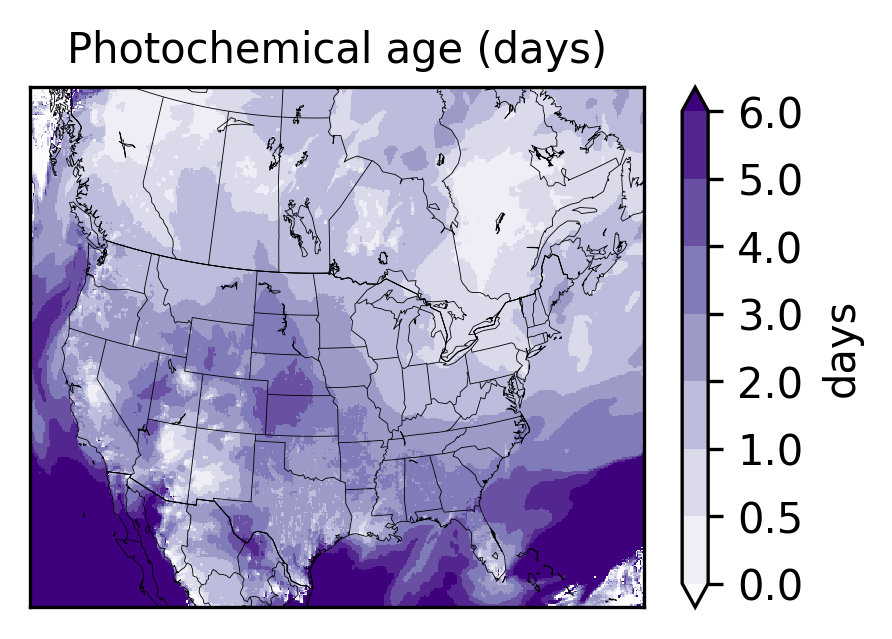

In [21]:
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['figure.figsize'] = [5/2.54*1.3, 3.3/2.54*1.3]
plt.rcParams['figure.figsize'] = [3.3, 4.5/2]
f1, sax = plt.subplots(1,1,dpi=300)
plt.sca(sax)
conc = bentoltime
lab = 'days'
colmap = plt.get_cmap('Purples')
levelsforplot = [0,0.5,1,2,3,4,5,6]
plotvar = conc.plot(cmap=colmap,levels=levelsforplot,edgecolor=None)
sax.axes.set_xticks([])
sax.axes.set_yticks([])
title= 'Photochemical age (days)'
set_map( ax=plotvar, title=title, colorlabel=lab )
plt.show()

# Benzene map

/home/phavala/.local/lib/python3.9/site-packages/matplotlib/colors.py:737: RuntimeWarning: invalid value encountered in less
  mask_under = xa < 0
/home/phavala/.local/lib/python3.9/site-packages/matplotlib/colors.py:738: RuntimeWarning: invalid value encountered in greater_equal
  mask_over = xa >= self.N


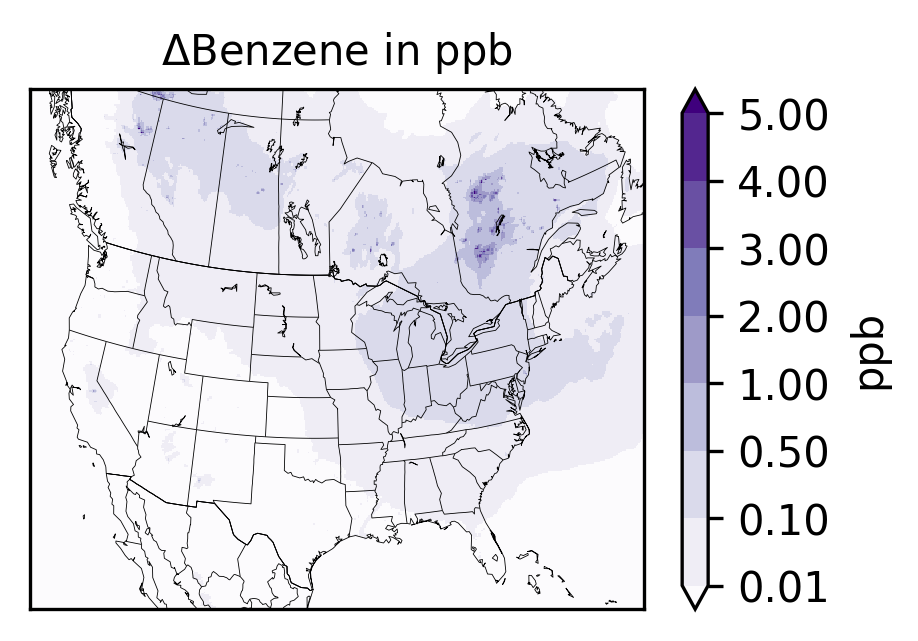

In [22]:
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['figure.figsize'] = [5/2.54*1.3, 3.3/2.54*1.3]
plt.rcParams['figure.figsize'] = [3.3, 4.5/2]
f1, sax = plt.subplots(1,1,dpi=300)
plt.sca(sax)
conc = benzene_ppb
lab = 'ppb'
colmap = plt.get_cmap('Purples')
levelsforplot = [0.01,0.1,0.5,1,2,3,4,5]
plotvar = conc.plot(cmap=colmap,levels=levelsforplot,edgecolor=None)
sax.axes.set_xticks([])
sax.axes.set_yticks([])
title= '$\Delta$Benzene in ppb'
set_map( ax=plotvar, title=title, colorlabel=lab )
plt.show()

# CO map

/home/phavala/.local/lib/python3.9/site-packages/matplotlib/colors.py:737: RuntimeWarning: invalid value encountered in less
  mask_under = xa < 0
/home/phavala/.local/lib/python3.9/site-packages/matplotlib/colors.py:738: RuntimeWarning: invalid value encountered in greater_equal
  mask_over = xa >= self.N


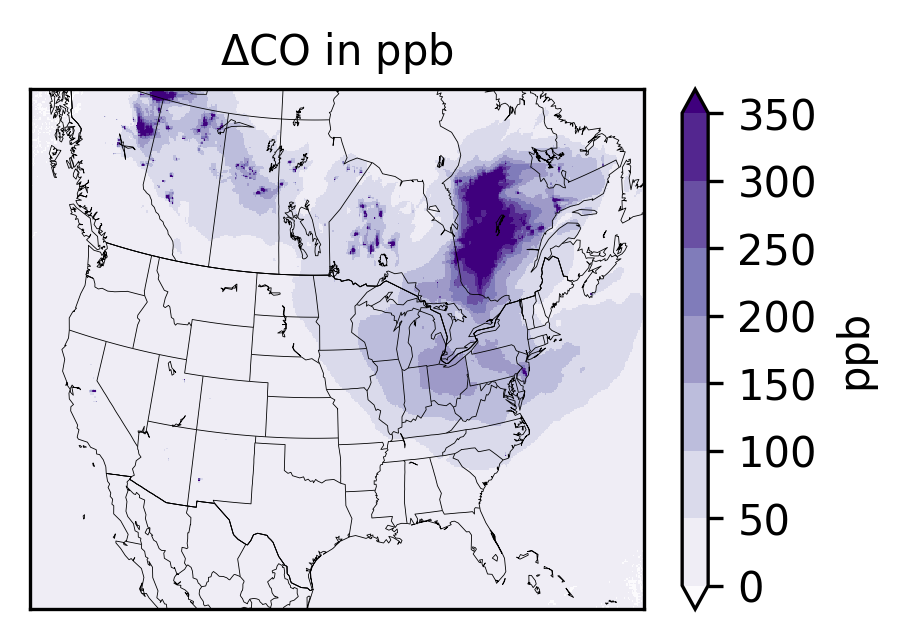

In [23]:
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['figure.figsize'] = [5/2.54*1.3, 3.3/2.54*1.3]
plt.rcParams['figure.figsize'] = [3.3, 4.5/2]
f1, sax = plt.subplots(1,1,dpi=300)
plt.sca(sax)
conc = co_ppb
lab = 'ppb'
colmap = plt.get_cmap('Purples')
levelsforplot = [0,50,100,150,200,250,300,350]
plotvar = conc.plot(cmap=colmap,levels=levelsforplot,edgecolor=None)
sax.axes.set_xticks([])
sax.axes.set_yticks([])
title= '$\Delta$CO in ppb'
set_map( ax=plotvar, title=title, colorlabel=lab )
plt.show()

**PNC:/home/phavala/.local/lib/python3.9/site-packages/PseudoNetCDF/pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF
**PNC:/home/phavala/.local/lib/python3.9/site-packages/PseudoNetCDF/pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF
**PNC:/home/phavala/.local/lib/python3.9/site-packages/PseudoNetCDF/pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF
**PNC:/home/phavala/.local/lib/python3.9/site-packages/PseudoNetCDF/pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF
**PNC:/home/phavala/.local/lib/python3.9/site-packages/PseudoNetCDF/pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF
**PNC:/home/phavala/.local/lib/python3.9/site-packages/PseudoNetCDF/pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF
**PNC:/home/phavala/.local/lib/python3.9/site-packages/PseudoNetCDF/pn

NYC 0.95158994 12.820763 NY
Chicago 1.0777879 12.526935 Ch
Toronto 0.71331316 14.536686 To
Montreal 0.7944435 10.970475 Mo
Vancouver 1.5036621 0.1754551 Va
Calgary 1.1002543 2.6199465 Ca
Ottawa 0.6478576 20.299885 Ot
Edmonton 1.3536474 4.17813 Ed
MacKenzie Co. 0.46551284 12.991386 Ma
Winnipeg 1.5178015 5.500083 Wi
Atlanta 3.0071683 2.9444122 At
NYC 0.95158994 0.08275717 NY
Chicago 1.0777879 0.08698339 Ch
Toronto 0.71331316 0.09130306 To
Montreal 0.7944435 0.08418456 Mo
Vancouver 1.5036621 0.08927531 Va
Calgary 1.1002543 0.054942653 Ca
Ottawa 0.6478576 0.09407732 Ot
Edmonton 1.3536474 0.07173466 Ed
MacKenzie Co. 0.46551284 0.10421953 Ma
Winnipeg 1.5178015 0.08080177 Wi
Atlanta 3.0071683 0.067436114 At


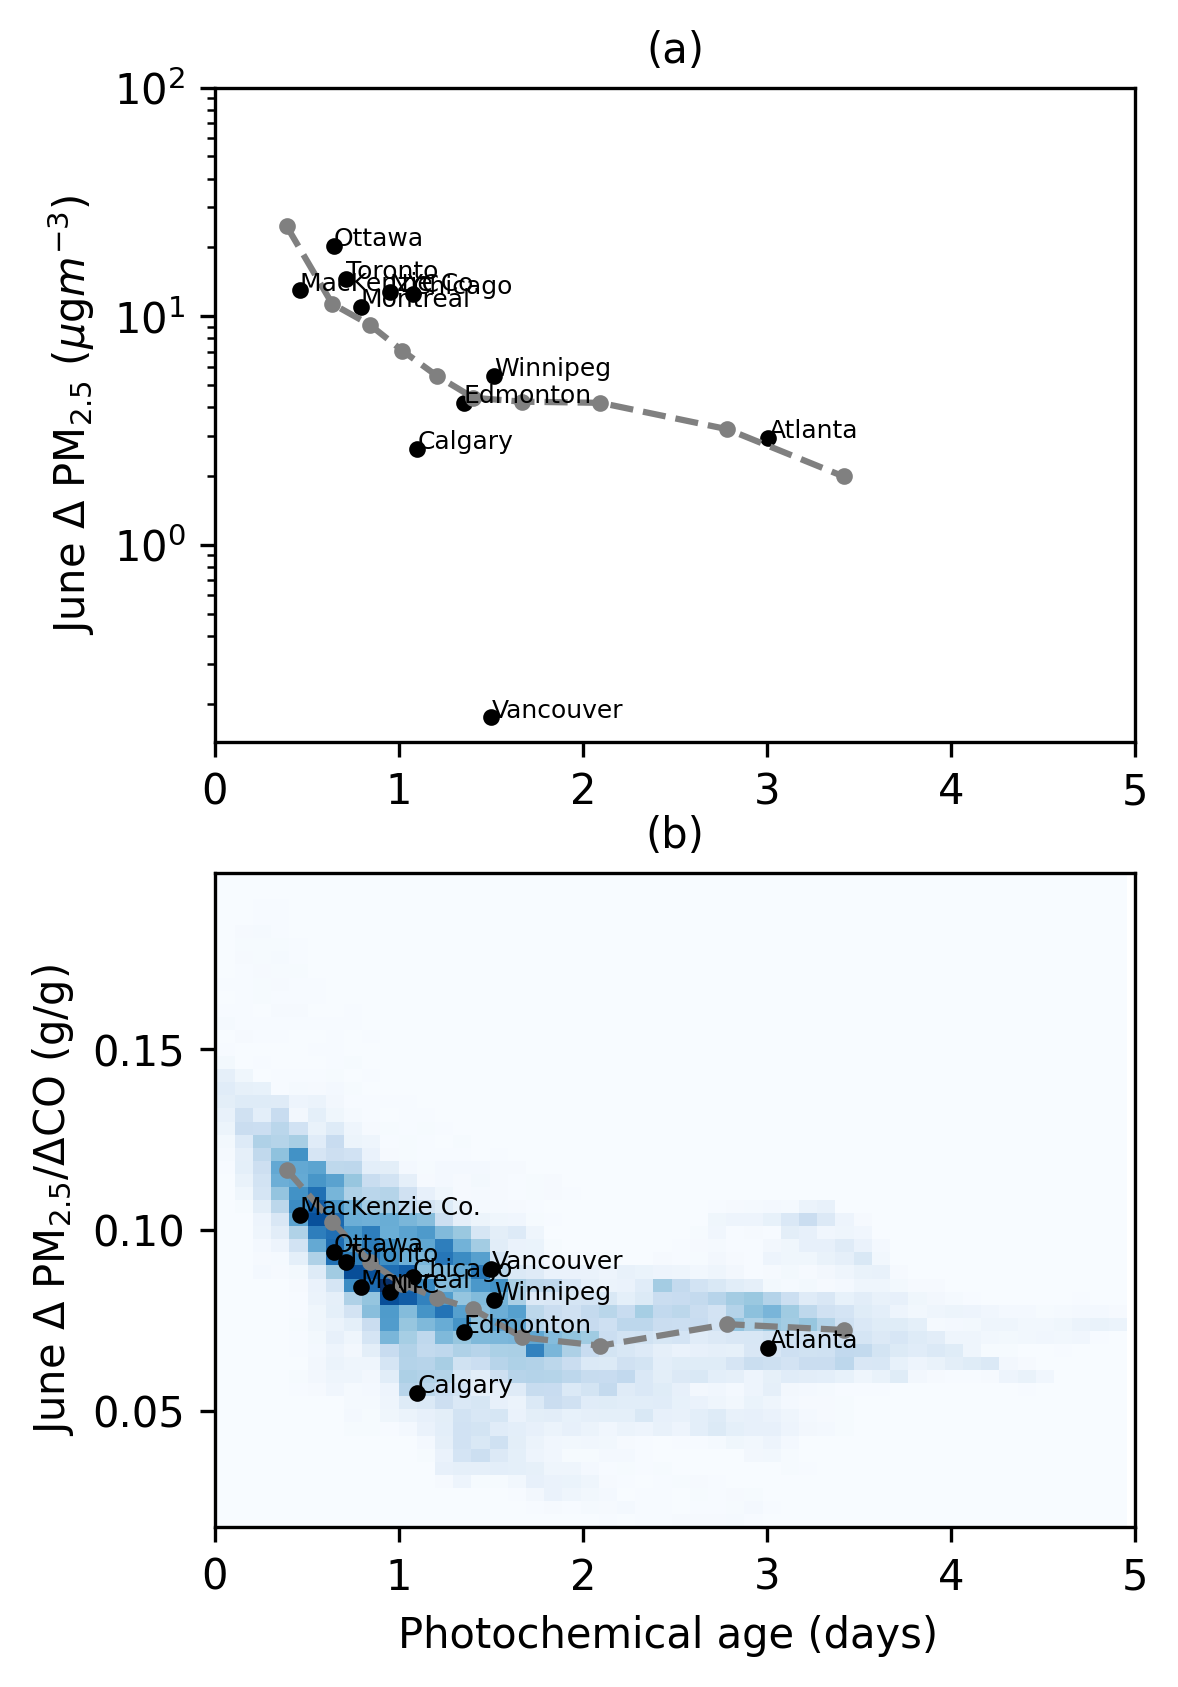

In [24]:
# PM2.5 vs time
panelfontsize=10
fig, rax = plt.subplots(
        2, 1, figsize=(3.3,9.9*2/3), gridspec_kw=dict(
            wspace=0.35, left=0.06,right=0.99,top=0.95,bottom=0.223
        ), dpi=300
    )

# Panel 0-add lines compared to above
ax=rax[0]

#using_hist2d(ax,dfplot['time'],np.log(dfplot['pm25']))
ax.plot(dfbin['time'], (dfbin['pm25']),'--',color='grey')
ax.plot(dfbin['time'], (dfbin['pm25']),'.',color='grey')
ax.set(xlabel=' ', 
       ylabel='June $\Delta$ PM$_{2.5}$ ($\mu$g$m^{-3}$)',yscale='log')#, xscale='log', yscale='log')
#ax.set(xlim=ax.get_xlim()[::-1])
ax.xaxis.set_tick_params(labelsize=panelfontsize)
ax.yaxis.set_tick_params(labelsize=panelfontsize)
ax.xaxis.label.set_size(panelfontsize)
ax.yaxis.label.set_size(panelfontsize)

for index,row in sites.iterrows():
        lonin = row['lon']
        latin = row['lat']
        i,j = grid.ll2ij(lonin, latin) # returns array i and array j
        sites.at[index,'gridi']=i
        sites.at[index,'gridj']=j
        sites.at[index,'gridcenterlat'] = np.array(grid.variables['LAT'][:, :, j, i].squeeze().data,ndmin=1)[0]
        sites.at[index,'gridcenterlon'] = np.array(grid.variables['LON'][:, :, j, i].squeeze().data,ndmin=1)[0]
    
        yval = np.array((pm25_ugm3.squeeze())[j,i].squeeze().data,ndmin=1)[0]
        xval = np.array(bentoltime[:,j,i].squeeze().data,ndmin=1)[0]
        print(row['site']+' '+str(xval)+' '+str(yval)+' '+row['site'][0:2])
        ax.text(xval,yval,row['site'],fontsize=6)
        
        ax.scatter(xval,yval,marker='.',color='black')

ax.set_title('(a)')

ax.set_xlim(0,5)
ax.set_ylim(0,100)

# panel 2, CO normalization
ax=rax[1]

using_hist2d(ax,dfplot['time'],dfplot['pmco_gg'])
ax.plot(dfbin['time'], dfbin['pmco_gg'],'--',color='grey')
ax.plot(dfbin['time'], dfbin['pmco_gg'],'.',color='grey')
ax.set(xlabel='Photochemical age (days) ', 
       ylabel='June $\Delta$ PM$_{2.5}$/$\Delta$CO (g/g)')#, xscale='log', yscale='log')
#ax.set(xlim=ax.get_xlim()[::-1])
ax.xaxis.set_tick_params(labelsize=panelfontsize)
ax.yaxis.set_tick_params(labelsize=panelfontsize)
ax.xaxis.label.set_size(panelfontsize)
ax.yaxis.label.set_size(panelfontsize)

for index,row in sites.iterrows():
        lonin = row['lon']
        latin = row['lat']
        i,j = grid.ll2ij(lonin, latin) # returns array i and array j
        sites.at[index,'gridi']=i
        sites.at[index,'gridj']=j
        sites.at[index,'gridcenterlat'] = np.array(grid.variables['LAT'][:, :, j, i].squeeze().data,ndmin=1)[0]
        sites.at[index,'gridcenterlon'] = np.array(grid.variables['LON'][:, :, j, i].squeeze().data,ndmin=1)[0]
    
        #yval = np.array((o3conc/coppb).squeeze()[j,i].squeeze().data,ndmin=1)[0]
        #yval = np.array((o3conc/coppb)[:,:,j,i].squeeze().data,ndmin=1)[0]
        yval =  np.array((pm25_ugm3.squeeze()/co_ugm3.squeeze())[j,i].data,ndmin=1)[0] 
    
        #print('o3 '+str((o3conc[:,:,j,i].squeeze()))
        #print('co '+str((coppb[:,:,j,i].squeeze()))

        #break
    
        xval = np.array(bentoltime[:,j,i].squeeze().data,ndmin=1)[0]
        print(row['site']+' '+str(xval)+' '+str(yval)+' '+row['site'][0:2])
        ax.text(xval,yval,row['site'],fontsize=6)
        
        ax.scatter(xval,yval,marker='.',color='black')

ax.set_title('(b)')
#ax.set_ylim(-.01,0.4)

ax.set_xlim(0,5)
#ax.set_ylim(0,2.6)


#fig.savefig(f'{outdir}/figs/{today}_FigS19_PMandO3vsage.png', bbox_inches='tight')
plt.show()